In [1]:
import sys
sys.path.append("../../")
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.image as mpimg
import time
import pandas as pd
from pandas.plotting import scatter_matrix
import h5py
#from tqdm.keras import TqdmCallback
from transport_nets.models.NVP import NVP

tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
file = h5py.File('BeamSamples.h5','r')
joint_samples = np.array(file['Samples/'],dtype=np.float32)
scaler = MinMaxScaler()
scaled_samples = scaler.fit_transform(joint_samples)

# loading model structure and wieghts
model_path = 'models/nvp/model.h5py'
weights_path = 'models/nvp/weights.h5py'
nvp = NVP(load_model=model_path)
nvp.load_weights(weights_path)

<Figure size 1080x1080 with 0 Axes>

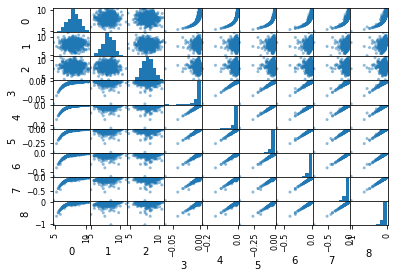

In [3]:
plt.figure(figsize=(15,15))
scatter_matrix(pd.DataFrame(joint_samples[::100,:]))
plt.show();

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


<Figure size 1080x1080 with 0 Axes>

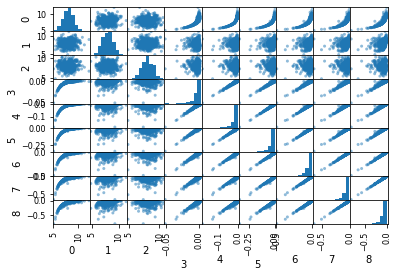

In [4]:
fig = plt.figure(figsize=(15,15))
x_forward = scaler.inverse_transform(nvp.sample(500).numpy())
scatter_matrix(pd.DataFrame(x_forward))
plt.show();

### Algorithm 1 RTO Metropolis–Hastings (RTO-MH)

1. Find $v_{ref}$ using (3)  

$$(3)\qquad v_{ref} = arg \min_{v} \frac{1}{2} ||H(v)||^2 $$

2. Determine $\nabla H(v_{ref})$
3. Compute Q, whose columns are an orthonomal basis for the range of $\nabla H(v_{ref})$
4. for $i=1,...,n_{samps}$ do in parallel
5. &nbsp;&nbsp;&nbsp;&nbsp; Sample $\eta^{(i)}$ from an (n+m) dimensional standard normal distribution
6. &nbsp;&nbsp;&nbsp;&nbsp; Solve for a proposal sample $v_{prop}^{(i)}$ using (5)
7. &nbsp;&nbsp;&nbsp;&nbsp; Compute $w(v_{prop}^{(i)})$ from (8)

$$(5) \qquad v_{prop}^{(i)} = arg \min_{v} \frac{1}{2}\left|\left|Q^T(H(v)-\eta^{(i)})\right|\right|^{\ 2}$$

$$(8) \qquad w(v) = |det(Q^T \nabla H(v))|^{-1}exp\left(-\frac{1}{2}||H(v)||^2 + \frac{1}{2}||Q^TH(v)||^2\right)$$

8. Set $v^{(0)} = v_{ref}$
9. for $i=1,...,n_{samps}$ do in series
10. &nbsp;&nbsp;&nbsp;&nbsp; Sample $t$ from a uniform distribution on $[0,1]$
11. &nbsp;&nbsp;&nbsp;&nbsp; if $t < w(v_{prop}^{(i)})\ /\ w(v^{i-1})$ then
12. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $v^{(i)} = v_{prop}^{(i)}$
13. &nbsp;&nbsp;&nbsp;&nbsp; else
14. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $v^{(i)} = v^{(i-1)}$

In [5]:
from transport_nets.mcmc import RTO_MetropolisHastings
num_params = 3
test_values = np.array(file['TestValues'],dtype=np.float32)
m_y_scaled = scaler.transform(np.reshape(test_values,(1,-1)))
y_obs = m_y_scaled[0,num_params:]
noise_std = 0.01
N_samples=2000
rto_mh = RTO_MetropolisHastings(num_params=num_params, y_obs=y_obs, model = nvp, noise_std = noise_std)
# time bar only for sequential sampling part
# self.ref_samples attribute created during run, which are final samples before forward pass
target_samples, acc_rate, time_total = rto_mh.run(N_samples)                                                           
X = scaler.inverse_transform(target_samples.numpy())

100%|██████████| 1999/1999 [00:57<00:00, 34.78it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



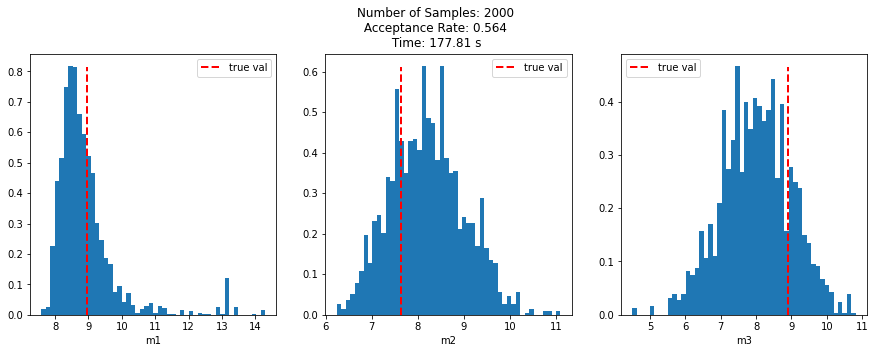

In [7]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
m1,m2,m3 = tuple(test_values[:num_params])

axs[0].hist(X[:,0],50,density=True)
axs[0].axvline(m1,ymax=0.95,c='r',ls='--',lw=2.0,label='true val')
axs[0].set_xlabel('m1')
axs[0].legend()

axs[1].hist(X[:,1],50,density=True)
axs[1].axvline(m2,ymax=0.95,c='r',lw=2.0,ls='--',label='true val')
axs[1].set_xlabel('m2')
axs[1].legend()

axs[2].hist(X[:,2],50,density=True)
axs[2].axvline(m3,ymax=0.95,c='r',lw=2.0,ls='--',label='true val')
axs[2].set_xlabel('m3')
axs[2].legend()

plt.suptitle('Number of Samples: %d\n Acceptance Rate: %0.3f \n Time: %0.2f s'%(N_samples,acc_rate,time_total))
plt.subplots_adjust(top=0.85)
plt.savefig('NVP-RTO-MH-Euler-Beam.png')